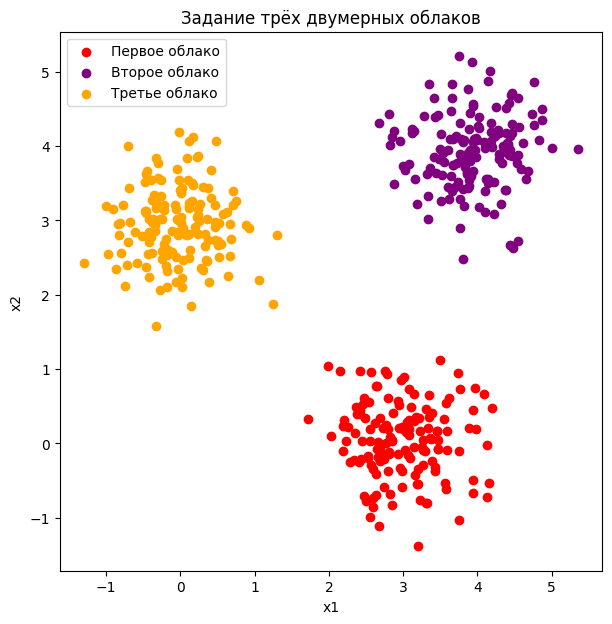

In [ ]:
### шаг 1: создание трёх двумерных облаков
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
N = 150

# генерируем три двумерных облака
first_cloud = np.random.normal(loc=[3, 0], scale=0.5, size=(N, 2))
second_cloud = np.random.normal(loc=[4, 4], scale=0.5, size=(N, 2))
third_cloud = np.random.normal(loc=[0, 3], scale=0.5, size=(N, 2))

# визуализация
plt.figure(figsize=(7,7))
plt.scatter(first_cloud[:,0], first_cloud[:,1], color='red', label='Первое облако')
plt.scatter(second_cloud[:,0], second_cloud[:,1], color='purple', label='Второе облако')
plt.scatter(third_cloud[:,0], third_cloud[:,1], color='orange', label='Третье облако')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Задание трёх двумерных облаков')
plt.show()


In [ ]:
### шаг 2: растягивание облаков до пятимерного пространства
# объединяем все облака в один массив для удобства
all_clouds = np.vstack([first_cloud, second_cloud, third_cloud])

# новые признаки
x1 = all_clouds[:, 0] # исходная x коорд
x2 = all_clouds[:, 1] # исходная y коорд
x3 = x1 + x2
"""
можно добавить + 1e-5, чтобы log всегда был конечным числом (иначе
может провалиться)
"""
x4 = np.log(np.abs(x1)) + x2
x5 = np.sin(x1 * x2)

# формируем 5D облако
"""
все манипуляции выше нужны для того, чтобы "растянуть"
пространство до 5d (ака пяти признаков, по которым будет работать PCA). и вместо
привычного нам (x,y) признака расположения точки у нас будет точка являться
вектором с ещё x3 числом, логарифом и синусом сверху (по которым PCA сможет
уловить структуру облаков и отделить их лучше)
"""
clouds_5d = np.column_stack([x1, x2, x3, x4, x5])
print(clouds_5d.shape)  # должно быть 450 (150 точек по 3 облака) и 5 признаков


(450, 5)


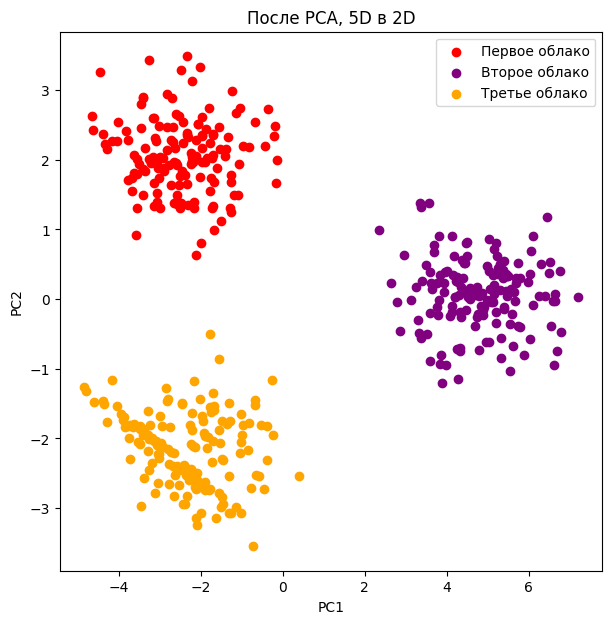

In [ ]:
### шаг 3: отделение главных компонент (PCA)
from sklearn.decomposition import PCA

"""
у sklearn есть встроенный PCA
"""
pca = PCA(n_components=2) # уменьшаем размерность с 5D до 2D
clouds_2d = pca.fit_transform(clouds_5d)

"""
про PCA на наших 5D точках, что произошло:
    * PCA ищет две новые оси (PC1 и PC2), которые сохраняют
    максимальную дисперсию
    * каждая точка становится редуцированным вектором из 2D
    * третье облако — почти прямая линия, из-за того,
    что x1 ~0, а x2 ~3 => как итог признаки сильно коррелированы
    * (!!!!) первые два облака объёмные, потому что x1, x2 больше, как
    итог полученные x3, x4, x5 дают больше вариаций, ну и облака сохраняют
    "объёмную" форму (хотя координаты повернулись) -> смотрим по цветам

ИТОГ: форма точек сильно изменилась, но различия между облаками сохраняются
"""
plt.figure(figsize=(7,7))
plt.scatter(clouds_2d[:N,0], clouds_2d[:N,1], color='red', label='Первое облако')
plt.scatter(clouds_2d[N:2*N,0], clouds_2d[N:2*N,1], color='purple', label='Второе облако')
plt.scatter(clouds_2d[2*N:,0], clouds_2d[2*N:,1], color='orange', label='Третье облако')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('После PCA, 5D в 2D')
plt.show()


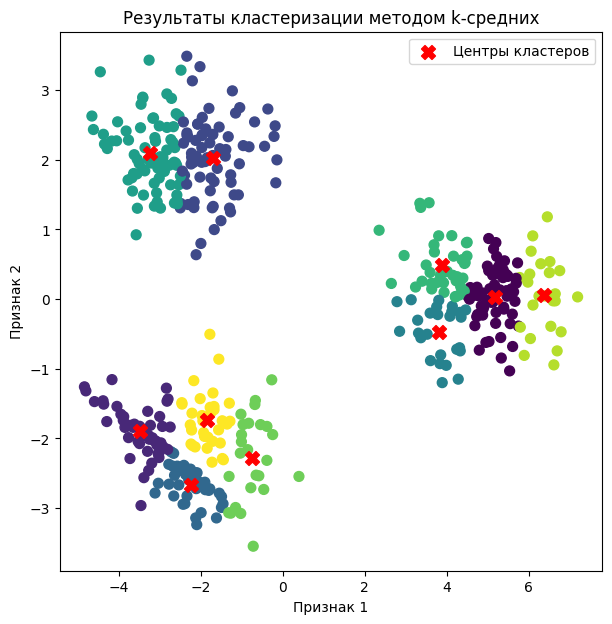

In [ ]:
#шаг 4: кластеризация двумерных точек. после проверить будут ли 3 кластера оптимальными
#принцип к средних
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters = 10) #здесь можно указать количество кластеров
kmean.fit(clouds_2d)
labels = kmean.labels_
plt.figure(figsize=(7,7))
centroids = kmean.cluster_centers_
plt.scatter(clouds_2d[:, 0], clouds_2d[:, 1], c=labels,s = 50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s = 100, label='Центры кластеров')
plt.title("Результаты кластеризации методом k-средних")
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.legend()
plt.show()


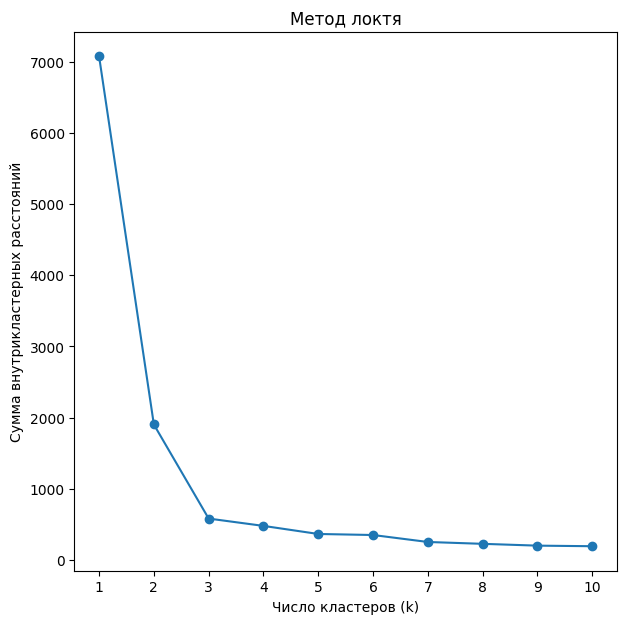

In [ ]:
#метод локтя для оценки оптимальности
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(clouds_2d)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(7,7))
plt.plot(range(1, 11), inertia, marker='o')
plt.xticks(range(1, 11))
plt.title("Метод локтя")
plt.xlabel("Число кластеров (k)")
plt.ylabel("Сумма внутрикластерных расстояний")
plt.show()
#на графике видно, что как раз таки наш локоть попадает на число 3 , поэтому 3 и есть оптимальное еколичество кластеров